The idea will be near identical as the one step decoder except we will now generate samples from the whole dataset, so the nn could denoise a variety of digits.

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

#The dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

#normalize - We normalize to keep the learning parameter eta more efficient
test_images = test_images/255.0
train_images = train_images/255.0

In [3]:
def add_Gaussian_noise(Beta_schedule, samples):  
    noise = np.random.normal(0, Beta_schedule, size= (samples, 28,28))
    return noise

Let's create the new addition: Creating noisy data...

In [16]:
samp_size = train_images.shape
print(train_images.shape)

num_sam =5 #5 noisy samples
#For readability, we create the 1 noisy sample for each MNIST sample image
Tensor_of_noise_samples = np.zeros((num_sam, 60000,28,28))
Tensor_of_noise_only = np.zeros((num_sam, 60000,28,28))

Tensor_of_noise_samples_test = np.zeros((num_sam, 10000,28,28))
Tensor_of_noise_only_test = np.zeros((num_sam, 10000,28,28))

for i in range(num_sam):
    print(i)
    #for training
    Noise_for_samples = add_Gaussian_noise(.4, len(train_images))
    Noisy_samples_i = train_images + Noise_for_samples
    Tensor_of_noise_samples[i,:,:,:] = Noisy_samples_i
    Tensor_of_noise_only[i,:,:,:] = Noise_for_samples

    #for testing
    Noise_for_samples_test = add_Gaussian_noise(.4, len(test_images))
    Noisy_samples_i_test = test_images + Noise_for_samples_test
    Tensor_of_noise_samples_test[i,:,:,:] = Noisy_samples_i_test
    Tensor_of_noise_only_test[i,:,:,:] = Noise_for_samples_test



plt.figure()
plt.imshow(Tensor_of_noise[1,3,:,:])

plt.figure()
plt.imshow(Tensor_of_noise[2,2,:,:])


(60000, 28, 28)
0
1
2


Now we have organized our data into Tensor, that is the first index represents noise subtensor we would like to look at. The second index j tells us which sample from test_images we need to look at, and the the 3rd and 4th indices are the pixel values for the jth sample. So if I would like to select the all n noisy samples of the jth MNIST sample, i would index as follows: [:,j,:,:] 

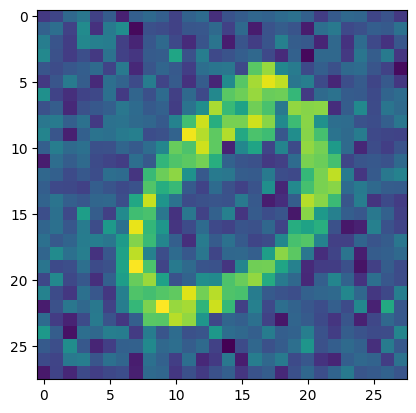

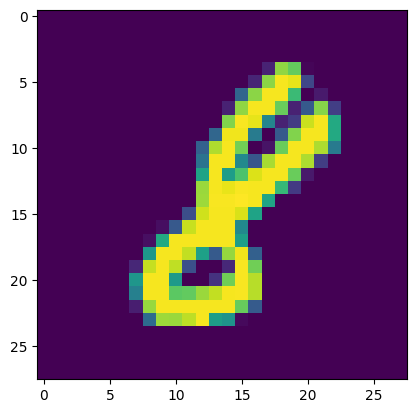

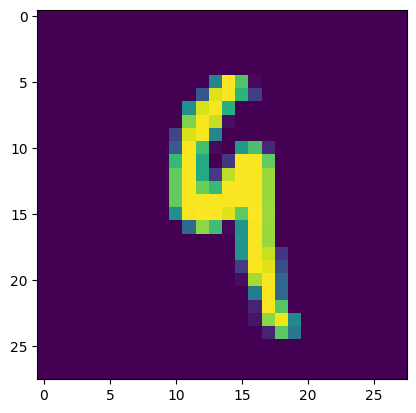

In [5]:
#for training
Noise_only = Tensor_of_noise_only.reshape((len(train_images)*num_sam, 28,28))
NSamples = Tensor_of_noise_samples.reshape((len(train_images)*num_sam, 28,28))
y = np.random.permutation((len(train_images)*num_sam))
shuffled_noise_only = Noise_only[y,:,:]
shuffled_noise= NSamples[y,:,:]

#for testing
Noise_only_test = Tensor_of_noise_only_test.reshape((len(test_images)*num_sam, 28,28))
NSamples_test = Tensor_of_noise_samples_test.reshape((len(test_images)*num_sam, 28,28))

#apart by 10000
plt.figure()
plt.imshow(NSamples[1,:,:])
plt.figure()
plt.imshow(NSamples[1+10000,:,:]- Noise_only[1+10000,:,:])
plt.figure()
plt.imshow(shuffled_noise[1,:,:]-shuffled_noise_only[1,:,:])


Creating the model

In [6]:
#instantiating the model class in tensorflow
pred_model1 = models.Sequential()


pred_model1.add(tf.keras.layers.Conv2D(filters = 32, kernel_size =(3,3), padding = 'same', activation='relu',input_shape=(28, 28, 1))) # CNN 32 filter (1, 28,28, 32)

pred_model1.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2),
    padding='valid'
)) # max pooling

#pred_model1.add(tf.keras.layers.Conv2D(filters = 32, kernel_size =(4,4), padding = 'same', activation='relu',input_shape=(28, 28, 1))) # second CNN 32 filter


pred_model1.add(tf.keras.layers.Flatten())  #flatten 

#pred_model1.add(tf.keras.layers.Dense(784,activation='relu',use_bias=True)) # first dense layer with 784

pred_model1.add(tf.keras.layers.Dense(784,activation='linear',use_bias=True)) # output  layer with 784 neurons

pred_model1.compile(optimizer='adam', loss= 'mse', metrics=['mse', 'mae'])

C:\Users\ianau\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Modify the data to allow inpout into the CNN

In [7]:
#for training
shuffled_noise_only_in = shuffled_noise_only.reshape((num_sam*len(train_images),28*28))

shuffled_noise_in = np.expand_dims(shuffled_noise,axis=-1)
print(shuffled_noise_in.shape)
print(shuffled_noise_only_in.shape)

#for testing
Noise_only_test_in = Noise_only_test.reshape((num_sam*len(test_images),28*28))

NSamples_test_in = np.expand_dims(NSamples_test,axis=-1)

(300000, 28, 28, 1)
(300000, 784)


In [8]:
pred_model1.fit(shuffled_noise_in, shuffled_noise_only_in, epochs=10)

Epoch 1/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 243s 26ms/step - loss: 0.0243 - mae: 0.1213 - mse: 0.0243
Epoch 2/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 246s 26ms/step - loss: 0.0148 - mae: 0.0938 - mse: 0.0148
Epoch 3/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 250s 27ms/step - loss: 0.0139 - mae: 0.0905 - mse: 0.0139
Epoch 4/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 253s 27ms/step - loss: 0.0134 - mae: 0.0887 - mse: 0.0134
Epoch 5/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 254s 27ms/step - loss: 0.0131 - mae: 0.0875 - mse: 0.0131
Epoch 6/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 251s 27ms/step - loss: 0.0128 - mae: 0.0864 - mse: 0.0128
Epoch 7/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 250s 27ms/step - loss: 0.0126 - mae: 0.0855 - mse: 0.0126
Epoch 8/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 267s 27ms/step - loss: 0.0124 - mae: 0.0847 - mse: 0.0124
Epoch 9/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 255s 27ms/step - loss: 0.0122 - mae: 0.0839 - mse: 0.0122
Epoch 10/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 257s 27ms/step - loss: 0.0121 - mae: 0.0833 - mse: 0.0121

Evaluating Denoising model

In [11]:
b = pred_model1.evaluate(NSamples_test_in, Noise_only_test_in, verbose=2)


1563/1563 - 6s - 4ms/step - loss: 0.0122 - mae: 0.0837 - mse: 0.0122


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


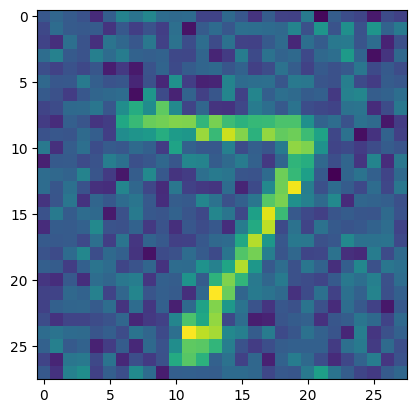

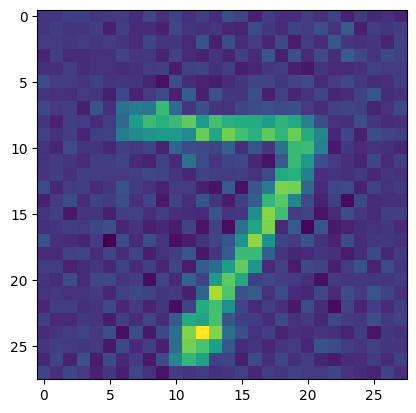

In [15]:
#Let's sample from the test images:

#given a 28,28 MNIST image
def denoising_function(input_image):
     ii = np.expand_dims(input_image, axis=-1)
     ii = np.expand_dims(ii, axis=0)
     pred_noise = pred_model1.predict(ii)
     final = input_image - pred_noise.reshape((28,28))
     return final

test_image = NSamples_test[0,:,:]
plt.imshow(test_image)
denoised_img_test = denoising_function(test_image)

#plotting the figure
plt.figure()
plt.imshow(denoised_img_test)